In [1]:
import ast
import itertools
import sys
from pathlib import Path

import h5py as h5
import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm

sys.path.append('../lib')
from local_paths import preproc_dir, analysis_dir, database_dir, cache_dir
from storage import get_storage_functions, quantize
from hier_group import unpack_hier_names
from im_patches import get_patches_from_grid
from cross_val_pred import standardize, cv_split_by_image, cv_ridge_predict_eval

# Parameters

In [2]:
#============================================================================
# session
#============================================================================
sess_name = 'sess_name'


#============================================================================
# saccade-matching
#============================================================================
min_sep = 4  # for non-matched fixation


#============================================================================
# spatiotemporal resolution of RF
#============================================================================
# temporal
t_aln  = 'sacc_on'  # 'sacc_on' or 'fix_on'
t_win  = 0  # if > 0, uses single window
t_offset = None  # default: -t_win/2; time bin center = t_offset + t_loc or timing
# - if t_win > 0
t_loc  = None  # if set, supercedes timing_path and t_col
# -- if t_loc is None
t_col  = None
# - if t_win <= 0
t_pre  = 375
t_post = 375  # inclusive, but window must fit fully in range
t_step =  25

# spatial
rloc_min  = -0.5  # normalized to saccade length
rloc_max  =  1.5
rloc_step =  0.25


#============================================================================
# modelling
#============================================================================
# ridge regularization
ridge_alpha = 100000

# cross-validation
n_splits    =      5
group_kfold =   True


#============================================================================
# statistical tests
#============================================================================
n_perm = 0
match_test = ('original', 'previous', 0, 'greater')


#============================================================================
# paths
#============================================================================
proc_dir = preproc_dir

sdf_dir = preproc_dir
sdf_suffix = '-mwa_1' if t_win > 0 else '-mwa_50'  # default to no smoothing if using a response window

rsc_dir = analysis_dir + 'self_consistency_no_decorr'

feat_dir = cache_dir + 'feats/vit_large_patch16_384/blocks.13.attn.qkv'
feat_suffix = '_as_2x2_in_0.50_steps'

unit_sel_path = database_dir+'unit_sel/visually_selective.csv.gz'
rf_fit_path = database_dir + 'per_unit_rf.csv.gz'
timing_path = database_dir + 'timing-mpm_peaks.csv.gz'

output_dir = analysis_dir + 'mas_match_control'

In [3]:
# Parameters
sess_name = "Pa210201"
output_dir = "../test_results"


# Check prereqs and params

In [4]:
proc_path = Path(proc_dir) / (sess_name + '-proc.h5')
print('Loading shared processing from', proc_path)
proc_path = proc_path.expanduser()
assert proc_path.is_file()

sdf_path = Path(sdf_dir) / (sess_name + f'-sdf{sdf_suffix}.h5')
print('Loading spike density function from', sdf_path)
sdf_path = sdf_path.expanduser()
assert sdf_path.is_file()

rsc_path = Path(rsc_dir) / (sess_name + '.h5')
print('Loading return fixation self-consistency results from', rsc_path)
rsc_path = rsc_path.expanduser()
assert rsc_path.is_file()

with h5.File(proc_path, 'r') as f:
    im_w, im_h = im_size = f['stimulus/size_dva'][()]
feats_path = Path(feat_dir) / f'{im_w:.1f}x{im_h:.1f}{feat_suffix}.h5'
print('Loading cached model features from', feats_path)
feats_path = feats_path.expanduser()
assert feats_path.is_file()

rf_fit_path = Path(rf_fit_path)
print('Loading Gaussian-fitted RF maps density function from', rf_fit_path)
rf_fit_path = rf_fit_path.expanduser()
assert rf_fit_path.is_file()

if unit_sel_path is not None and unit_sel_path != 'None':
    print('Loading unit selection from', unit_sel_path)
    unit_sel_path = Path(unit_sel_path).expanduser()
    assert unit_sel_path.is_file()
    unit_names = pd.read_csv(unit_sel_path).set_index('Session').loc[[sess_name]]['Unit'].values
else:
    unit_names = None

if t_win > 0:
    t_pre = t_post = t_step = np.nan
    if t_offset is None: t_offset = -t_win / 2
    if t_loc is None:
        assert timing_path is not None and t_col is not None
        t_loc = np.nan
        print('Using per-unit timing from', timing_path)
        print('\tColumn:', t_col, '\tOffset:', t_offset)
        timing_path = Path(timing_path).expanduser()
        assert timing_path.is_file()
    else:
        t_col = ''
else:
    t_loc = t_offset = np.nan
    t_col = ''

output_dir = Path(output_dir)
assert output_dir.expanduser().is_dir()
output_path = output_dir / (sess_name + '.h5')
print('Saving results to', output_path)
output_path = output_path.expanduser()

Loading shared processing from ../test_data/Pa210201-proc.h5
Loading spike density function from ../test_data/Pa210201-sdf-mwa_50.h5
Loading return fixation self-consistency results from ../test_results/self_consistency_no_decorr/Pa210201.h5
Loading cached model features from ~/Data/FreeViewing/Cache/feats/vit_large_patch16_384/blocks.13.attn.qkv/16.0x16.0_as_2x2_in_0.50_steps.h5
Loading Gaussian-fitted RF maps density function from ../db/per_unit_rf.csv.gz
Loading unit selection from ../db/unit_sel/visually_selective.csv.gz
Saving results to ../test_results/Pa210201.h5


In [5]:
if n_perm > 0:
    if isinstance(match_test, str):
        match_test = ast.literal_eval(match_test)
    else:
        assert isinstance(match_test, tuple)
    assert match_test[0] == 'original'  # placeholder, for consistency
    assert match_test[1] in ('previous', 'current')
    assert isinstance(match_test[3], str)  # alternative to test

In [6]:
analysis_name = 'mas_match_control'

if output_path.is_file():
    with h5.File(output_path, 'r') as f:
        try:
            if f[f'progress_report/{analysis_name}/all_done'][()].item():
                raise RuntimeError(f'{sess_name} has already been processed')
        except KeyError:
            pass

In [7]:
fix_df = pd.read_hdf(proc_path, 'fixation_dataframe', 'r')
with h5.File(proc_path, 'r') as f:
    stim_folder_ = f['stimulus/folder'][()].decode()

imids = fix_df.groupby(['Image subdir', 'Image filename']).first().index
md5s = [Path(fn).stem for _, fn in imids]
md5_catalog = pd.DataFrame(index=imids, data=md5s, columns=['MD5'])

# Prepare parameters; save config

In [8]:
with h5.File(proc_path, 'r') as f:
    random_seed = f['config/default_random_seed'][()]
print('random_seed:', random_seed)

random_seed: 775418045


In [9]:
assert t_aln in ('sacc_on', 'fix_on')
if t_win > 0:
    ts = np.array([t_win/2]) + t_offset  # placeholder; actual window varies with latency per unit
else:
    ts = np.arange(-t_pre, t_post+.1, t_step)
print(f'{len(ts)} response windows')

rf_rlocs = np.arange(rloc_min, rloc_max+rloc_step/10, rloc_step)
if n_perm > 0 and match_test[2] is not None:
    assert match_test[2] in rf_rlocs  # control loc in stat test is unique to this analysis
print('RF locations (along saccade vector, normalized by saccade size):')
print(f'{rf_rlocs} ({len(rf_rlocs)})')

31 response windows
RF locations (along saccade vector, normalized by saccade size):
[-0.5  -0.25  0.    0.25  0.5   0.75  1.    1.25  1.5 ] (9)


In [10]:
save_results, add_attr_to_dset, check_equals_saved, link_dsets, copy_group = \
    get_storage_functions(output_path)

In [11]:
group = analysis_name + '/'
save_results(group+'ts', ts, attrs=dict(unit='ms'))
save_results(group+'rf_rlocs', rf_rlocs, attrs=dict(unit='normalized'))
save_results(group+'sdf_suffix', sdf_suffix)

group = analysis_name + '/config/'
save_results(group+'random_seed', random_seed)

group = analysis_name + '/config/match_criterion/'
save_results(group+'min_sep', min_sep)

group = analysis_name + '/config/time_windows/'
save_results(group+'t_aln', t_aln)
save_results(group+'t_win', t_win)
save_results(group+'t_loc', t_loc)
save_results(group+'t_col', t_col)
save_results(group+'t_offset', t_offset)
save_results(group+'t_pre', t_pre)
save_results(group+'t_post', t_post)
save_results(group+'t_step', t_step)
add_attr_to_dset(group, attrs=dict(unit='ms'))

group = analysis_name + '/config/positions_along_saccade/'
save_results(group+'rloc_min', rloc_min)
save_results(group+'rloc_max', rloc_max)
save_results(group+'rloc_step', rloc_step)
add_attr_to_dset(group, attrs=dict(unit='normalized'))

group = analysis_name + '/config/modelling/'
save_results(group+'n_splits', n_splits)
save_results(group+'ridge_alpha', ridge_alpha)
save_results(group+'group_kfold', group_kfold)

group = analysis_name + '/config/statistics/'
save_results(group+'n_perm', n_perm)
save_results(group+'match_test', str(match_test))

# Define RFs

In [12]:
if unit_names is None:
    with h5.File(sdf_path, 'r') as f:
        unit_names = f['sdf'].attrs['unit_names'].astype(str)

unit_names0 = unit_names.copy()
unit_names = unpack_hier_names(unit_names)
unit_names = unit_names[unit_names[:,0]=='Unit', 1]

In [13]:
unit_rf_df = pd.read_csv(rf_fit_path).set_index('Session')
assert sess_name in unit_rf_df.index, 'No unit has good RF fits'

unit_rf_df = unit_rf_df.loc[[sess_name]].set_index('Name')
assert not unit_rf_df.index.has_duplicates
unit_names = unit_rf_df.index.intersection(unit_names).values
print(f'{len(unit_names)} of {len(unit_names0)} ({(len(unit_names)/len(unit_names0))*100:.1f}%) units have fitted RFs')

unit_rf_df = unit_rf_df.loc[unit_names].reset_index()
assert len(unit_rf_df) == len(unit_names)
print('Num units using RF fit from each source:')
print('\t' + '\n\t'.join(str(unit_rf_df.groupby('Source').count()['x']).split('\n')[:-1]))

52 of 52 (100.0%) units have fitted RFs
Num units using RF fit from each source:
	Source
	Channel     3
	Default    11
	Unit       38


In [14]:
save_results(analysis_name+'/unit_names', unit_names.astype(bytes))
unit_rf_df.to_hdf(output_path, analysis_name+'/rf_per_unit', mode='a', format='table', complevel=9, complib='zlib')

# Find matched saccades

In [15]:
with h5.File(rsc_path, 'r') as f:
    fix1_sel, fix2_sel = f['self_consistency/saccade_selection'][()]
    return_thres = f['self_consistency/config/return_criterion/return_thres'][()]
    v = f['self_consistency/return_pairs/'+match_test[1]][()]
    assert v.size
    v = np.sort(v, axis=1)
    v = v[np.lexsort(tuple(v.T))]
    match_return_pairs = v

In [16]:
rg = np.random.default_rng(random_seed)
pair_df = pd.DataFrame(np.concatenate([match_return_pairs, match_return_pairs[:,::-1]], axis=0)).set_index(0)
if match_test[1] == 'previous':
    src_fix_sel, other_fix_sel = fix1_sel, fix2_sel
else:
    src_fix_sel, other_fix_sel = fix2_sel, fix1_sel
matched = np.zeros(fix1_sel.size, dtype=bool)
match_ips = []

for i, (src_ifix, other_ifix) in enumerate(zip(src_fix_sel, other_fix_sel)):
    try:
        match_ip_opts = pair_df.loc[[i],1].values
    except KeyError:
        continue
    assert len(set(match_ip_opts)) == len(match_ip_opts)
    match_ip_opts = rg.permuted(match_ip_opts)
    for ip in match_ip_opts:
        match_other_ifix = other_fix_sel[ip]
        other_xy, match_other_xy = fix_df.iloc[[other_ifix, match_other_ifix]]\
            [['Relative X', 'Relative Y']].values
        if np.linalg.norm(other_xy - match_other_xy) >= min_sep:
            matched[i] = True
            match_ips.append(ip)
            break

print(f'{matched.sum()} of {matched.size} ({matched.mean()*100:.1f}%) saccades had matched {match_test[1]} fixation '
      f'and min. sep. >= {min_sep} dva for the unmatched fixation')
match_fix1_sel = fix1_sel[match_ips]
match_fix2_sel = fix2_sel[match_ips]
fix1_sel = fix1_sel[matched]
fix2_sel = fix2_sel[matched]

786 of 4037 (19.5%) saccades had matched previous fixation and min. sep. >= 4 dva for the unmatched fixation


In [17]:
# sanity check
cols = ['Relative X', 'Relative Y']
xy1 = fix_df.iloc[fix1_sel][cols].values
mxy1 = fix_df.iloc[match_fix1_sel][cols].values
xy2 = fix_df.iloc[fix2_sel][cols].values
mxy2 = fix_df.iloc[match_fix2_sel][cols].values
d1 = np.linalg.norm(xy1 - mxy1, axis=1)
d2 = np.linalg.norm(xy2 - mxy2, axis=1)
if match_test[1] != 'previous':
    d1, d2 = d2, d1
assert (d1 < return_thres).all()
assert (d2 >= min_sep).all()
for sel, msel in ((fix1_sel, match_fix1_sel), (fix2_sel, match_fix2_sel)):
    assert (fix_df.iloc[sel]['Image filename'].values == fix_df.iloc[msel]['Image filename'].values).all()

In [18]:
group = analysis_name + '/config/match_criterion/'
save_results(group+'return_thres', min_sep)

group = analysis_name + '/saccade_selection/'
save_results(group+'fixation_indices', np.array([fix1_sel, fix2_sel]))
save_results(group+'match_saccades/fixation_indices', np.array([match_fix1_sel, match_fix2_sel]))

# Get aligned responses

In [19]:
with h5.File(sdf_path, 'r') as f:
    dset = f['sdf']
    all_unit_names = list(dset.attrs['unit_names'].astype(str))
    unit_sel = np.array([v in unit_names for v in all_unit_names])
    sdf = dset[()][:,unit_sel]

n_neur = sdf.shape[1]

In [20]:
if t_win > 0:
    if np.isfinite(t_loc):
        timing = pd.DataFrame(data={'Index': np.arange(len(unit_names)), 'Timing': np.full(unit_names.size, t_loc)})
    else:
        timing = pd.read_csv(timing_path).set_index('Session').loc[[sess_name]].set_index('Name')
        m = pd.Series(unit_names).isin(timing.index)
        assert m.all(), f'missing timing values for {(~m).sum()} of {m.size} units'
        assert not timing.index.has_duplicates
        timing = timing.loc[unit_names].reset_index()
        assert len(timing) == len(unit_names)
        timing = timing[[t_col, 'Source']].rename(columns={t_col: 'Timing'})
        timing['Timing'] += t_offset
        timing['Index'] = np.arange(len(timing))
        print('Num units using RF fit from each source:')
        print('\t' + '\n\t'.join(str(timing.groupby('Source').count()['Timing']).split('\n')[:-1]))

    # for quick illustrative plotting only; does not affect response timing
    ts += timing['Timing'].values.mean()

    timing.to_hdf(output_path, analysis_name+'/timing_per_unit', mode='a', format='table', complevel=9, complib='zlib')

In [21]:
if t_aln == 'sacc_on':
    t0s = fix_df.iloc[fix1_sel][['Time', 'Duration']].values.sum(1)
    mt0s = fix_df.iloc[match_fix1_sel][['Time', 'Duration']].values.sum(1)
else:
    t0s = fix_df.iloc[fix2_sel]['Time'].values
    mt0s = fix_df.iloc[match_fix2_sel]['Time'].values

resps = np.empty_like(sdf, shape=(fix2_sel.size, ts.size, sdf.shape[-1]))
mresps = np.empty_like(resps)

if t_win > 0:
    t_win_ = np.array([0, t_win])
    lat_groups = [(dt, df_['Index'].values) for dt, df_ in timing.groupby('Timing')]
    for resps_, t0s_ in ((resps, t0s), (mresps, mt0s)):
        for i, t in enumerate(t0s_):
            for dt, usel in lat_groups:
                s = slice(*np.round(t+dt+t_win_).astype(int))
                resps_[i,0,usel] = sdf[s,usel].mean(0)
else:
    for resps_, t0s_ in ((resps, t0s), (mresps, mt0s)):
        for i, t in enumerate(t0s_):
            ts_ = np.round(t+ts).astype(int)
            resps_[i] = sdf[ts_,:]

del sdf

Y = standardize(resps)
match_Y = standardize(mresps)

del resps, mresps

# Define splits (group k-fold)

In [22]:
imfns = fix_df.iloc[fix2_sel]['Image filename']

splits, train_mask = cv_split_by_image(
    imfns, n_splits,
    group_kfold=group_kfold, random_seed=random_seed)

For group k-fold, loading catalog of similar images
accounting for 0 pairs of similar images
num training and testing points per split:
split 0		train:   629 test: 157
split 1		train:   629 test: 157
split 2		train:   628 test: 158
split 3		train:   628 test: 158
split 4		train:   630 test: 156


In [23]:
save_results(analysis_name+'/fix_is_train', train_mask, attrs=dict(
    dims=np.array(['split', 'fixation'], dtype=np.bytes_),
    random_seed=random_seed,
    group_kfold=group_kfold))

# Load pre-computed model reprs

In [24]:
with h5.File(feats_path, 'r') as f:
    patch_locs_x = f['config/patch_grid/x_locs'][()]
    patch_locs_y = f['config/patch_grid/y_locs'][()]
    patch_step = float(f['config/patch_grid/step'][()])

    bg_feats = f['feats/bg'][()]

    all_md5s = f['md5'][()].astype(str)
    all_md5s = pd.Series(index=all_md5s, data=np.arange(len(all_md5s)), name='Index in file')
    idc = all_md5s.loc[md5_catalog['MD5'].values]
    md5_catalog['Index'] = np.arange(len(md5_catalog))

    patch_grid_feats = np.empty(shape=(idc.size,patch_locs_x.size,patch_locs_y.size)+bg_feats.shape, dtype=bg_feats.dtype)
    for ii, i in enumerate(idc.values):
        patch_grid_feats[ii] = f['feats/patch_grid'][i]  # shape (n_patches_x, n_patches_y,) + feats_shape

    copy_group(f, 'config', analysis_name+'/config/feats')

feats_shape = bg_feats.shape
print('Features shape:', feats_shape)
print('Patch-grid features shape:', patch_grid_feats.shape)

iims = np.array([
    md5_catalog.loc[(row['Image subdir'], row['Image filename']), 'Index']
    for i, (_, row) in enumerate(fix_df.iloc[fix2_sel].iterrows())])
patch_bins_x = np.concatenate([
    patch_locs_x-patch_step/2, [patch_locs_x[-1]+patch_step/2]])
patch_bins_y = np.concatenate([
    patch_locs_y-patch_step/2, [patch_locs_y[-1]+patch_step/2]])

Features shape: (3072,)
Patch-grid features shape: (793, 35, 35, 3072)


In [25]:
def recon_stim(*args, **kwargs):
    return get_patches_from_grid(
        *args, patch_bins_x=patch_bins_x, patch_bins_y=patch_bins_y, **kwargs)

# Main

In [26]:
xys_fix1 = fix_df.iloc[fix1_sel][['Relative X', 'Relative Y']].values.astype(float)
xys_fix2 = fix_df.iloc[fix2_sel][['Relative X', 'Relative Y']].values.astype(float)
sacc_vecs = xys_fix2 - xys_fix1

In [27]:
n_win = len(ts)
n_split = n_splits
n_loc = len(rf_rlocs)
n_unit = len(unit_names)
n_fix = fix2_sel.size

cv_corrs = np.full((2, n_win, n_loc, n_unit), np.nan, dtype=np.float32)
cv_corrs_per_split = np.full((2, n_win, n_split, n_loc, n_unit), np.nan, dtype=np.float32)
if n_perm > 0:
    dsamps = np.empty_like(cv_corrs_per_split[0])
    dperms = np.empty_like(dsamps, shape=(n_perm,)+dsamps.shape)

In [28]:
unit_rf_df['Index'] = np.arange(len(unit_rf_df))
gb = unit_rf_df.groupby(['x', 'y'])

for (igroup, ((rf_x, rf_y), df_)), (il, rloc) in tqdm(
        itertools.product(enumerate(gb), enumerate(rf_rlocs)),
        total=len(gb)*len(rf_rlocs)):
    usel = df_['Index'].values
    xys = xys_fix1 + [rf_x, rf_y] + rloc * sacc_vecs
    X = standardize(recon_stim(iims, xys, patch_grid_feats, bg_feats))

    Yu = Y[...,usel]
    match_Yu = match_Y[...,usel]

    for i, Y_ in enumerate((Yu, match_Yu)):
        corr, _, corr_pers, _ = cv_ridge_predict_eval(X, Y_, splits, alpha=ridge_alpha)
        cv_corrs[i,:,il,usel] = corr.T
        cv_corrs_per_split[i,:,:,il,usel] = corr_pers.transpose(2,0,1)

    if n_perm > 0:
        dsamps[...,il,usel] = np.diff(cv_corrs_per_split[...,il,usel], axis=0)[0]

        rg = np.random.default_rng(random_seed)  # fine, even preferable, to use same randomization across loops
        both_Yu = np.concatenate([Yu, match_Yu], axis=0)
        idc = np.arange(len(both_Yu))
        dperms_ = np.empty((n_perm, n_win, n_split, usel.size))
        for iperm in range(n_perm):
            idc = rg.permuted(idc)
            idc1, idc2 = np.split(idc, 2)
            dperms_[iperm] = (
                cv_ridge_predict_eval(X, both_Yu[idc2], splits, alpha=ridge_alpha)[2]
                - cv_ridge_predict_eval(X, both_Yu[idc1], splits, alpha=ridge_alpha)[2])
        dperms[:,...,il,usel] = dperms_

100%|██████████████████████████████████████▊| 242/243 [1:12:26<00:16, 16.10s/it]

100%|███████████████████████████████████████| 243/243 [1:12:38<00:00, 14.94s/it]

100%|███████████████████████████████████████| 243/243 [1:12:38<00:00, 17.94s/it]

In [29]:
# calculate permutation p-values
if n_perm > 0:
    alt = match_test[3]
    if match_test[2] is not None:
        ilt = list(rf_rlocs).index(match_test[2])
        dsamps -= dsamps[...,[ilt],:]
        dperms -= dperms[...,[ilt],:]
    else:
        ilt = None
    if alt == 'two-sided':
        d = np.abs(dsamps) - np.abs(dperms)
    elif alt == 'less':      # original < match
        d = dsamps - dperms
    else:                    # original > match
        d = dperms - dsamps  # d(2)samp ~ match - original < 0
    d = np.ma.masked_invalid(d)  # correlation can be nan
    # splits do not meaningfully differ w.r.t. the test, so pool them
    d = d.transpose(0,2,1,3,4).reshape(-1, d.shape[1], d.shape[3], d.shape[4])
    p = 1 - (d > 0).mean(0)
    # permutation p is lower-bound by (valid) num perms
    pvals = np.clip(p, 1 / (1 + (~d.mask).sum(0)), None).filled(np.nan)
    if ilt is not None:
        pvals[:,ilt,:] = np.nan

In [30]:
dims = np.array(('condition', 'time', 'split', 'pos', 'unit'))
coords = dict((
    ('condition', np.array(('original', 'match'))),
    ('time', ts),
    ('pos', rf_rlocs),
    ('unit', unit_names)))
attrs = dict(
    n_sacc=fix1_sel.size,
    group_kfold=int(group_kfold),
    feat_shape=feats_shape,
    ridge_alpha=ridge_alpha,
    t_aln=t_aln)

q = lambda x: quantize(x, 3)
data_vars = {
    'corr': (dims[[0,1,3,4]], q(cv_corrs)),
    'corr_per_split': (dims, q(cv_corrs_per_split))}
if n_perm > 0:
    data_vars['p-value'] = (dims[[1,3,4]], pvals)
dataset = xr.Dataset(data_vars, coords=coords, attrs=attrs)

compr = dict(zlib=True, complevel=9)
encoding = {
    k: dict(chunksizes=v.shape, **compr)
    for k, v in dataset.data_vars.items()}
dataset.to_netcdf(
    output_path, group=analysis_name+'/data',
    mode='a', engine='h5netcdf', encoding=encoding)

# Wrap up

In [31]:
save_results(f'progress_report/{analysis_name}/all_done', True)

In [32]:
%load_ext watermark
%watermark
%watermark -vm --iversions -rbg

Last updated: 2024-02-19T21:56:50.185516-05:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.12.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.0-92-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

Git hash: b0bb10f45dee065cc3af96fe224326b883d27431

Git repo: https://github.com/willwx/free_viewing_staging.git

Git branch: master

pandas: 2.0.1
numpy : 1.24.3
xarray: 2023.4.2
sys   : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
h5py  : 3.8.0



# Basic visualization of results

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

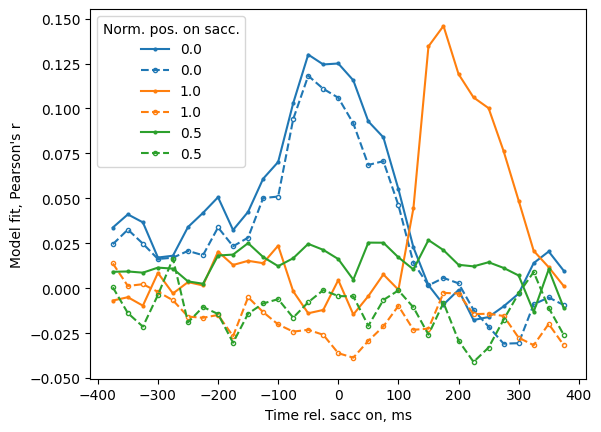

In [34]:
ms = np.nanmean(cv_corrs, -1)
for l, c in zip((0, 1, .5), ('tab:blue', 'tab:orange', 'tab:green')):
    i = np.argmin(np.abs(rf_rlocs - l))
    for j, ls in enumerate(('-', '--')):
        plt.plot(ts, ms[j,:,i], label=rf_rlocs[i], color=c, ls=ls,
                 marker='.', markerfacecolor=(c,'none')[j], markeredgecolor=('none',c)[j])
plt.legend(title='Norm. pos. on sacc.')
plt.xlabel(f'Time rel. {t_aln.replace("_", " ")}, ms')
plt.ylabel('Model fit, Pearson\'s r');

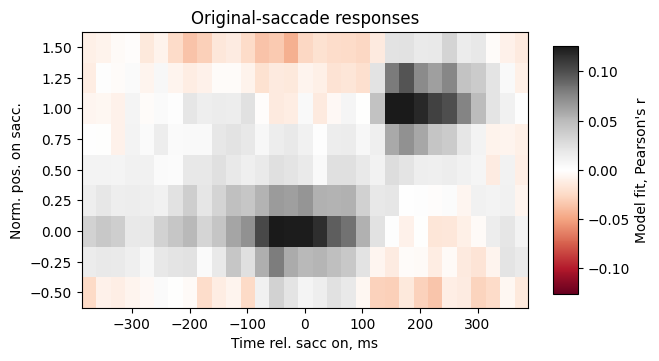

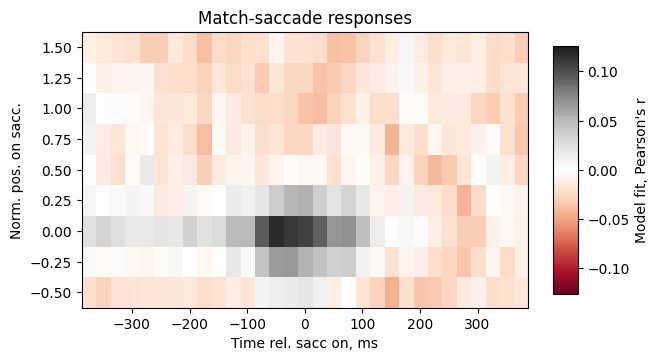

In [35]:
vr = abs(np.nanpercentile(ms, 99.5))

t_step_ = t_win if t_win > 0 else t_step
x_step_ = rloc_step
ext = (ts[0]-t_step_/2, ts[-1]+t_step_/2, rf_rlocs[0]-x_step_/2, rf_rlocs[-1]+x_step_/2)
aspect = np.array(ext).reshape(2,2).ptp(1)
aspect = aspect[0] / aspect[1] * .618

for i in range(2):
    plt.figure()
    cm = plt.imshow(
        ms[i].T, extent=ext,
        origin='lower', aspect=aspect,
        cmap='RdGy', vmin=-vr, vmax=vr)
    cb = plt.colorbar(cm, fraction=.05, aspect=10)
    cb.ax.set_ylabel('Model fit, Pearson\'s r')
    plt.ylabel('Norm. pos. on sacc.')
    plt.xlabel(f'Time rel. {t_aln.replace("_", " ")}, ms')
    plt.title(('Original','Match')[i] + '-saccade responses')

In [36]:
if n_perm > 0:
    ms = (pvals < 0.01).mean(2)
    plt.figure()
    cm = plt.imshow(
        ms.T, extent=ext,
        origin='lower', aspect=aspect,
        cmap='gray_r', vmin=0, vmax=1)
    cb = plt.colorbar(cm, fraction=.05, aspect=10)
    cb.ax.set_ylabel('Frac. sig. neurons')
    plt.ylabel('Norm. pos. on sacc.')
    plt.xlabel(f'Time rel. {t_aln.replace("_", " ")}, ms');

In [37]:
if n_perm > 0:
    ms = np.median(pvals, 2)
    if np.isfinite(ms).any():
        vm = np.nanmax(ms)
        plt.figure()
        cm = plt.imshow(
            ms.T, extent=ext,
            origin='lower', aspect=aspect,
            cmap='gray_r', vmin=0, vmax=vm)
        cb = plt.colorbar(cm, fraction=.05, aspect=10)
        cb.ax.set_ylabel('Median p-value')
        plt.gca().set_facecolor('firebrick')
        plt.ylabel('Norm. pos. on sacc.')
        plt.xlabel(f'Time rel. {t_aln.replace("_", " ")}, ms');